<h1 style="font-size: 36px;">Probabilités numériques - Nano Projet n°3 - Théo Jalabert</h1>

<p style="font-size: 30px;">
   Simulation des deltas d'options vanilles (Call & Put) pour différents prix d'exercice en utilisant les méthodes suivantes :
</<ul style="list-style-type: none;">
    <li style="font-size: 25px;">Calcul par la simulation de la prime de l'option</li>
    <li style="font-size: 25px;">Méthode par lot (Batch Method)</li>
    <li style="font-size: 25px;">Méthode du praticien (Practitioner's Method)</li>
    <li style="font-size: 25px;">Méthode adaptative (Adaptive Method)</li>
</ul>

<p></p>


L'objectif de ce nano-projet est d'estimer le prix d'une option vanille en utilisant différentes méthodes d'estimation dans le cadre du modèle de Black-Scholes. 
Le prix de l'actif sous-jacent est noté $S_{T}^{x}$, et sa dynamique sous la probabilité risque neutre $\mathbb{Q}$ est donnée par : $$dS_t^x = S_t^x ( r \, dt + \sigma \, dW_t)$$
où :
- $W_t$ est un mouvement brownien sous $\mathbb{Q}$,
- $r \geq 0$ est le taux sans risque,
- $\sigma > 0$ est la volatilité,
- $S_0^x = x > 0$ représente la valeur initiale de l'actif sous-jacent.

### 1. Création des fonctions et méthodes de base

#### 1.1. Fonctions de base

In [8]:
# Importation des bibliothèques essentielles
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import time

Nous initialisons l'espace et nous générons les processus aléatoires nécessaires. Ensuite, nous créons une fonction permettant de générer les trajectoires browniennes.

In [9]:
from numpy.random import default_rng, SeedSequence

# Initialisation d'une graine aléatoire
seed_sequence = SeedSequence()  
rng = default_rng(seed_sequence)  # Génération de séquences aléatoires

def brownian_simulation(paths : int, times : np.ndarray, increments : bool=False, rng: np.random.Generator = None) -> np.ndarray : 
    if rng is None : 
        rng = np.random.default_rng() # Crée une graine et un algorithme associé si aucun n'est fourni

    # Nous trions la discrétisation de notre temps et calculons la longueur à chaque instant pour déterminer la variance de nos processus gaussiens
    np.sort(times)
    time_lenght = np.diff(times).astype(np.float32)

    # Nous calculons les points 
    brownian_paths = (np.sqrt(time_lenght)*rng.standard_normal((paths, len(time_lenght)))).astype(np.float32)
    
    # Ne retourne que les incréments entre chaque point
    if increments : 
        return brownian_paths.ravel()
        
    # Retourne sinon les trajectoires du mouvement brownien, nécessitant la somme des incréments à partir de 0
    paths = np.hstack([np.zeros((paths,1)).astype(np.float32), np.cumsum(brownian_paths, axis=1)])
    
    return paths      

La dynamique de notre actif sous-jacent sous la probabilité neutre au risque $\mathbb Q$ est donnée par :

$$S_t = S_0e^{(r - \frac{\sigma^2}{2})t + \sigma W_t}$$

où : 
- $W_t$ est un mouvement brownien sous $\mathbb{Q}$, 
- $r \geq 0$ est le taux sans risque, 
- $\sigma > 0$ est la volatilité, 
- et $S_0^x = x > 0$ est la valeur initiale de l’actif sous-jacent.

Nous définissons donc une fonction pour générer le prix de notre actif sous-jacent à l’instant $T$.

In [10]:
# Certaines de nos méthodes nécessitent de générer deux séries de prix afin de réduire la variance
# Comme nous aurons besoin de générer deux séries de prix à partir du même espace probabiliste, 
# nous ajoutons une option pour choisir entre une ou deux séries de prix
# Nous pourrions également avoir besoin de retourner la trajectoire brownienne générée afin de calculer notre option 
# comme le montrera la formule fermée suivante pour les prix des options

def underlying_prices(S0, r, sigma, T, n, double_prices_series=False):
    brownian_paths = brownian_simulation(paths=n, times=np.array([0.0, T]), increments=True, rng=rng)

    # En raison de la symétrie du mouvement brownien géométrique, nous utilisons la valeur négative 
    # du mouvement brownien généré pour obtenir notre deuxième série de prix
    if double_prices_series:
        S1 = S0 * np.exp((r - 0.5 * (sigma**2)) * T + sigma * brownian_paths)
        brownian_paths = -brownian_paths
        S2 = S0 * np.exp((r - 0.5 * (sigma**2)) * T + sigma * brownian_paths)
        return S1, S2
    else:
        return S0 * np.exp((r - 0.5 * (sigma**2)) * T + sigma * brownian_paths)

Le payoff de l’option call à $T$ est donné par :

$$
\Pi_T^{\text{Call(T,K)}}(S_T^x) = (S_T^x-K)_+
$$

et celui de l’option put à $T$ est donné par :

$$
\Pi_T^{\text{Put(T,K)}}(S_T^x) = (K-S_T^x)_+
$$

Nous définissons donc des fonctions qui reproduisent ces payoffs, ainsi qu’une fonction pour générer directement notre payoff actualisé (actif sous-jacent, puis payoff actualisé).

In [11]:
def payoff_call(S, K): return np.maximum(S - K, 0)

def payoff_put(S, K): return np.maximum(K - S, 0)

# Comme le titre l’indique, nous générons nos prix et appliquons la fonction de payoff qui nous intéresse.
def generate_actualized_simulations_payoff (S0, r, sigma,K, T,n, payoff_function, double_prices_series = False):
    if double_prices_series : 
        S1,S2 = underlying_prices (S0, r, sigma, T,n,double_prices_series=True)
        S1 = S1.astype(np.float32)
        S2 = S2.astype(np.float32)
        S1 = np.exp(-r*T)*payoff_function(S1,K)
        S2 = np.exp(-r*T)*payoff_function(S2,K)
        return S1,S2
        
    else :                          
        S = underlying_prices (S0, r, sigma, T,n,double_prices_series = False).astype(np.float32)
        return np.exp(-r*T)*payoff_function(S,K)

Le prix d’un call à l’instant $t=0$ est donné par la formule de Black & Scholes :

$$C_0(T,K) = S_0\mathcal{N}(d_+) - Ke^{-rT}\mathcal{N}(d_-)$$

et le prix d’un put équivalent est donné par :

$$P_0(T,K) = C_0(T,K) - S_0 + Ke^{-rT}$$

où $\mathcal{N}$ est la fonction de répartition cumulative (CDF) d’une variable normale standard avec :

$$d_+ = \frac{\log\left(\frac{x}{Ke^{-rT}}\right)+\frac{\sigma^2}{2}T}{\sigma\sqrt{T}}.$$

et

$$d_- = d_+ - {\sigma\sqrt{T}}$$

Nous définissons donc nos fonctions pour calculer les prix théoriques exacts des options vanilles afin de mieux estimer la qualité de nos futurs estimateurs.

In [12]:
# Formule fermée de Black-Scholes
def call_price(S0, r, sigma, T, K,n=1) : 
    d1 = (np.log(S0/(K*np.exp(-r*T))) + (sigma**2)*(T/2))/(sigma*np.sqrt(T)).astype(np.float32)
    d2 = d1 - sigma*np.sqrt(T).astype(np.float32)
    call_price= S0*norm.cdf(d1) - K*(np.exp(-r*T))*norm.cdf(d2)
    return np.full(n, call_price).astype(np.float32)


#Using Call-Put parity
def put_price (S0, r, sigma, T, K,n=1) : 
    return call_price (S0, r, sigma, T, K,n)  - S0 + K*np.exp(-r*T).astype(np.float32)

Pendant la description et l’implémentation de chaque méthode, nous utiliserons la notation $X_k$ pour désigner la $k^{\text{ème}}$ simulation du payoff de notre option.

Nous supposons que la suite $ (X_k)_{k=1}^n $ est i.i.d. pour tout $n \geq 0$.

### Les méthodes utilisées : 

#### 1.2. Monte-Carlo Classique

Nous effectuons d’abord une simulation de Monte Carlo “classique”, c’est-à-dire sans modification de notre estimateur. Cette méthode a une variance élevée, que nous chercherons à réduire par la suite dans ce nano-projet.

$$
\sqrt{n} \left( \overline{X}_n - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_X^2) \quad \text{lorsque } n \to +\infty,
$$

avec
$$
\overline{X_n} = \frac{1}{n}\sum_{k=1}^n{X_k} \quad \text{et} \quad m_X = \mathbb{E}[X_1] \quad \text{et} \quad \sigma_X^2 = \mathbb{V}[X_1],
$$

et par conséquent, si nous définissons notre erreur comme suit :
$$
\epsilon_n = \overline{X}_n - m_X,
$$

nous pouvons en déduire que :
$$
\epsilon_n \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_X^2}{n}\right).
$$

In [13]:
def MC_option_simulation(S, serie=False, nb_simu=1000, var=False):

    # Nous pouvons choisir de retourner la série cumulée de MC pour avoir une meilleure idée de la convergence en fonction du nombre de simulations
    if serie:

        # Nous extrayons un sous-ensemble de plusieurs processus MC (nb_simu) 
        # pour observer la convergence de la série
        # Une première tentative, plus rapide, a été réalisée avec cumsum. Cependant, 
        # l'approximation par itérations successives a donné des résultats faux avec n > 1M.
        # Une approche utilisant une simulation MC unique via une approche récursive,
        # plus lente mais plus précise, a donc été choisie.
        indices = np.linspace(0, len(S), nb_simu, dtype=int)
        serie = np.array([MC_option_simulation(S[:i], serie=False, nb_simu=nb_simu, var=var) for i in indices])
        return serie

    else:

        # Nous pouvons choisir de retourner la variance de notre erreur en plus du prix MC
        if var:
            return np.mean(S), (len(S) / ((len(S) - 1)) * ((np.sum(S**2) / len(S)) - np.mean(S)**2)) / len(S)
        else:
            return np.mean(S)

#### 1.3 Méthode par lot (Batch Method)

Cette approche utilise une méthode antithétique visant à réduire la variance de notre erreur et ainsi améliorer la qualité des prédictions.
Nous introduisons une variable de contrôle dynamique $\lambda$ telle que :

$$
X^{\lambda} = X - \lambda \Xi
$$

où $X$ et $X’$ suivent la même distribution, c’est-à-dire :

$$
\mathbb{E}[X] = \mathbb{E}[X’] = m_X, \quad \mathbb{V}[X] = \mathbb{V}[X’] = \sigma_X^2
$$

mais avec $\mathbb{V}[X - X’] > 0$, et $\Xi$ est définie comme suit :

$$
\Xi = X - X’
$$

La variance de $X^{\lambda}$ est minimisée lorsque :

$$
\lambda_{\min} = \frac{\text{cov}(X, \Xi)}{\text{Var}[\Xi]}
$$

#### Configuration de la simulation

La simulation est réalisée en utilisant :

$$
\overline{X}_n^\lambda = \frac{1}{n} \sum\limits_{k=1}^n X_k^\lambda
$$

ou de manière équivalente :

$$
\overline{X}_n^\lambda = \overline{X}_n + \overline{\lambda}_n \overline{\Xi}_n
$$

avec :

$$
\overline{\lambda}_n = \frac{\frac{1}{n} \sum\limits_{k=1}^n X_k (X_k - X_k’)}{\frac{1}{n} \sum\limits_{k=1}^n (X_k - X_k’)^2}
$$

et :

$$
\overline{\Xi}_n = \frac{1}{n} \sum\limits_{k=1}^n (X_k - X_k’)
$$

#### Comportement asymptotique

Nous avons la convergence asymptotique suivante :

$$
\sqrt{n} \left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}(0, \sigma_{\min}^2) \quad \text{lorsque } n \to +\infty
$$

ou de manière équivalente :

$$
\left( \overline{X}_n^\lambda - m_X \right) \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \frac{\sigma_{\min}^2}{n}\right) \quad \text{lorsque } n \to +\infty
$$

avec :

$$
\sigma_{\min}^2 \leq \sigma_X^2
$$

In [14]:
def Batch_approach(S1, S2, serie=False, nb_simu=1000, parameters=False, var=False): 

    # Implémentation de theta
    theta = S1 - S2    

    # Nous pouvons choisir de retourner la série cumulée pour avoir une meilleure idée de la convergence selon le nombre de simulations
    if serie: 
        # Nous extrayons un sous-ensemble de processus MC (nombre de simulations) pour observer la convergence de la série
        # Une première tentative rapide avec cumsum a donné des résultats inexacts pour n > 1M
        # Une approche récursive, plus lente mais plus précise, a donc été choisie
        indices = np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Batch_approach(S1[:i], S2[:i], serie=False, nb_simu=nb_simu, parameters=parameters, var=var) for i in indices])   
        return serie 

    else: 
        # Création du paramètre lambda Batch utilisé pour calculer le prix estimé
        param_lambda = np.mean(S1 * theta) / np.mean(theta**2)
        
        if parameters: 
            return param_lambda
        else: 
            # Calcul de la moyenne des payoffs simulés et de theta pour le prix Batch
            S1_mean = np.mean(S1)
            theta_mean = np.mean(S1 - S2)
            
            if var: 
                # Calcul de la variance de l'erreur
                indices = np.arange(1, len(theta) + 1, dtype=np.float32)
                partial_theta_squared = theta**2
                cumulative_theta_squared = np.cumsum(partial_theta_squared)
                averaged_theta_squared = cumulative_theta_squared / indices
                epsilon = 1e-10
                averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)
                partial_lambda1 = S1 * theta
                cumulative_lambda1 = np.cumsum(partial_lambda1)
                averaged_lambda1 = cumulative_lambda1 / indices
                lambda1 = averaged_lambda1 / averaged_theta_squared

                return S1_mean - param_lambda * theta_mean, (len(S1) / (len(S1) - 1)) * ((np.sum(((S1 - lambda1 * theta)**2) / len(S1)) - np.mean(S1 - lambda1 * theta)**2)) / len(S1)
            else: 
                return S1_mean - param_lambda * theta_mean

#### 1.4. La méthode du practicien (Practitioner's Method)

En pratique, nous avons la relation suivante :

$$
\overline{X}_n^{\lambda_{\min}} = \overline{X}_n - \lambda_{\min} \overline{\Xi}_n
$$

En prenant l’espérance des deux côtés :

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = \mathbb{E}[\overline{X}_n] - \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

i.e.

$$
\mathbb{E}[\overline{X}_n^{\lambda_{\min}}] = m - \mathbb{E}[\lambda_{\min} \overline{\Xi}_n]
$$

Cependant, en pratique, $\mathbb{E}[\lambda_{\min} \overline{\Xi}_n] \neq 0$.

Pour résoudre ce problème, nous utilisons une approche appelée le “coin du praticien” :

Nous fixons $n’ < n$ et simulons $(X_k, X_k’)_{k=1}^{n’}$. Nous construisons $\hat{\lambda}$ tel que :

$$
\hat{\lambda}_{n’} = \frac{\frac{1}{n’} \sum\limits_{k=1}^{n’} X_k (X_k - X_k’)}{\frac{1}{n’} \sum\limits_{k=1}^{n’} (X_k - X_k’)^2}
$$

Puis nous construisons notre estimateur $\overline{X}_{n-n’+1}$ :

$$
\overline{X}_{n-n’} = \frac{1}{n-n’} \sum\limits_{k=n^{’}+1}^{n} X_k + \frac{\hat{\lambda}_{n’}}{n-n’} \sum\limits_{k=n^{’}+1}^{n} \Xi_k
$$

Nous obtenons alors :

$$
\mathbb{E}[\overline{X}_{n-n’}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n’} \overline{\Xi}_{n-n’}]
$$

ou équivalemment :

$$
\mathbb{E}[\overline{X}_{n-n’}^{\lambda_{\min}}] = m - \mathbb{E}[\hat{\lambda}_{n’}] \cdot \mathbb{E}[\overline{\Xi}_{n-n’}]
$$

Avec :

$$
\mathbb{E}[\overline{\Xi}_{n-n’}] = 0
$$

Ainsi, l’estimateur $\overline{X}_{n-n’}^{\lambda_{\min}}$ est sans biais.

In [15]:
def Practitioner_corner(S1, S2, serie=False, nb_simu=1000, var=False): 
    
    if serie:
        indices = np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Practitioner_corner(S1[:i], S2[:i], serie=False, nb_simu=nb_simu, var=var) for i in indices])   
        return serie 
    
    else: 
        n_1 = int(np.floor(0.15 * len(S1)))
        n_2 = len(S1) - n_1

        theta = S1 - S2
        lambda_practitioner = np.mean(S1[:n_1] * theta[:n_1]) / np.mean(theta[:n_1] ** 2)
        S1_mean = np.mean(S1[n_1+1:])
        theta_mean = np.mean(theta[n_1+1:])

        if var: 
            return S1_mean - lambda_practitioner * theta_mean, (len(S1[n_1:]) / (len(S1[n_1:]) - 1)) * ((np.sum(((S1[n_1:] - lambda_practitioner * theta[n_1:])**2) / len(S1[n_1:])) - np.mean(S1[n_1:] - lambda_practitioner * theta[n_1:])**2)) / len(S1[n_1:])
        else: 
            return S1_mean - lambda_practitioner * theta_mean

#### 1.5. Méthode adaptative (Adpative Method)

Une autre approche existe, appelée approche adaptative, pour résoudre ce problème de biais sans diviser l’effort comme dans le “coin du praticien”.

Nous définissons :

$$
\tilde{X}_k = X_k - \tilde{\lambda}_{k-1} \Xi_k
$$

où :

$$
\tilde{\lambda}_{k} = \big((-k) \lor \lambda_k\big) \land k
$$

avec $\lambda_k$ le paramètre provenant de notre approche par lot (Batch approach).

Notre estimateur est alors calculé comme suit :

$$
\overline{\tilde{X}}_n = \overline{X}_n - \frac{1}{n} \sum\limits_{k=1}^{n} \tilde{\lambda}_{k-1} \Xi_k
$$

ou :

$$
\overline{\tilde{X}}_n = \overline{X}_n - \tilde{\lambda}_{k-1} \overline{\Xi}_k
$$

In [16]:
def Adaptative_approach(S1, S2, serie=False, nb_simu=1000, var=False): 

    # Implémentation de theta
    theta = S1 - S2

    # Nous pouvons choisir de retourner la série cumulée pour avoir une meilleure idée de la convergence selon le nombre de simulations
    if serie:
        
        # Nous extrayons un sous-ensemble de processus MC (nombre de simulations) pour observer la convergence de la série
        # Une première tentative rapide avec cumsum a donné des résultats inexacts pour n > 1M
        # Une approche récursive, plus lente mais plus précise, a donc été choisie
        indices = np.linspace(0, len(S1), nb_simu, dtype=int)
        serie = np.array([Adaptative_approach(S1[:i], S2[:i], serie=False, nb_simu=nb_simu, var=var) for i in indices])   
        return serie 
     
    else: 

        # Calcul des payoffs simulés, de la moyenne de theta et du paramètre lambda, utilisés pour l'approche adaptative
        S1_mean = np.mean(S1)
        theta_mean = np.mean(S1 - S2)
        lambda_adaptative_one_price = min(max((np.mean(S1[:-1] * theta[:-1]) / np.mean(theta[:-1] ** 2)), -(len(S1) - 1)), len(S1) - 1)

        if var: 
            # Création de l'indice pour calculer les moyennes cumulées
            indices = np.arange(1, len(theta) + 1, dtype=np.float32)

            # Calcul des moyennes cumulées de theta²
            partial_theta_squared = theta**2
            cumulative_theta_squared = np.cumsum(partial_theta_squared)
            averaged_theta_squared = cumulative_theta_squared / indices

            # Sécurité pour éviter la division par zéro
            epsilon = 1e-10
            averaged_theta_squared = np.maximum(averaged_theta_squared, epsilon)

            # Calcul des lambda cumulés
            partial_lambda1 = S1 * theta
            cumulative_lambda1 = np.cumsum(partial_lambda1)
            averaged_lambda1 = cumulative_lambda1 / indices
            lambda1 = averaged_lambda1 / averaged_theta_squared
            
            # Application de la formule pour obtenir le paramètre adaptatif
            lambda_adaptative_no_shifted = np.maximum(-indices, np.minimum(lambda1, indices))
            
            # Décalage pour utiliser lambda_{k-1} dans le calcul récurrent
            lambda_adaptative = np.concatenate(([0], lambda_adaptative_no_shifted[:-1]))
            
            # Retourne le prix adaptatif et la variance de l'erreur sur la série cumulée
            return S1_mean - lambda_adaptative_one_price * theta_mean, (len(S1) / (len(S1) - 1)) * ((np.sum(((S1 - lambda1 * theta)**2) / len(S1)) - np.mean(S1 - lambda1 * theta)**2)) / len(S1)
            
        else: 
            # Retourne uniquement le prix adaptatif
            return S1_mean - lambda_adaptative_one_price * theta_mean

### 2. Fonction pour afficher les résultats

#### 2.1. Fonction pour afficher un DataFrame pandas contenant nos résultats

In [17]:
# Cette fonction affichera, pour chaque nombre de simulations, notre erreur ainsi que notre variance

def print_results_panda(S0, r, sigma, T, K, prix_option, payoff_function, n_values, series=False, title=""): 

    # Nous voulons mesurer le temps nécessaire pour calculer précisément nos prix et les payoffs associés
    beginning1 = time.time() 

    # Nous générons nos prix
    S1, S2 = underlying_prices(S0, r, sigma, T, max(n_values), double_prices_series=True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    
    # Pour construire notre structure de payoff, cela peut sembler contre-intuitif,
    # mais cela est plus rapide avec une boucle qu'avec zip (testé)
    S1_complete, S2_complete = [], []
    for f in payoff_function: 
        S1_complete.append(np.exp(-r*T) * f(S1, K))
        S2_complete.append(np.exp(-r*T) * f(S2, K))
        
    end1 = time.time() 
    execution_time1 = end1 - beginning1

    # Nous affichons le temps d'exécution
    print(f"Temps d'exécution pour la génération de {len(payoff_function) * max(n_values):,} prix et des payoffs associés : {execution_time1:.2f} secondes")

    # Nous itérons pour chaque type d'option que nous voulons afficher
    for i in range(len(prix_option)): 

        # Nous calculons notre prix de référence, c'est-à-dire celui de Black-Scholes
        BS_price = prix_option[i](S0, r, sigma, T, K, 1)

        times = np.array([]) 
        
        # Nous préparons nos tableaux numpy pour stocker nos données
        errors_mc = np.array([])
        errors_batch = np.array([])
        errors_practitioner = np.array([])
        errors_adaptative = np.array([]) 
        
        vars_mc = np.array([])
        vars_batch = np.array([])
        vars_practitioner = np.array([])
        vars_adaptative = np.array([]) 

        # Nous parcourons les différents nombres de simulations que nous voulons examiner
        for n in n_values :
    
            # Nous simulons notre payoff actualisé en fonction des prix simulés
            S1 = np.asarray(S1_complete[i][:n])
            S2 = np.asarray(S2_complete[i][:n])

            # Nous voulons chronométrer nos calculs pour vérifier si nous avons une relation linéaire
            # entre le nombre de simulations et le temps d'exécution des méthodes de réduction de variance
            beginning = time.time()  
    
            # Pour chaque méthode, nous calculons le prix, la variance et nous stockons l'erreur par rapport au prix BS et la variance
    
            # Méthode Monte Carlo classique
            mc_price, var_mc = MC_option_simulation(S1, serie=series, var=True)
            errors_mc = np.append(errors_mc, mc_price - BS_price)
            vars_mc = np.append(vars_mc, var_mc)
    
            # Méthode Batch
            batch_price, var_batch = Batch_approach(S1, S2, serie=series, var=True)
            errors_batch = np.append(errors_batch, batch_price - BS_price)
            vars_batch = np.append(vars_batch, var_batch)
    
            # Méthode Practitioner
            practitioner_price, var_practitioner = Practitioner_corner(S1, S2, serie=series, var=True)
            errors_practitioner = np.append(errors_practitioner, practitioner_price - BS_price)
            vars_practitioner = np.append(vars_practitioner, var_practitioner)
    
            # Méthode Adaptative
            adaptative_price, var_adaptative = Adaptative_approach(S1, S2, serie=series, var=True)
            errors_adaptative = np.append(errors_adaptative, adaptative_price - BS_price)
            vars_adaptative = np.append(vars_adaptative, var_adaptative)
    
            # Nous stockons notre temps d'exécution
            end = time.time() 
            execution_time = end - beginning
            times = np.append(times, execution_time)
    
        # Création de notre DataFrame pour afficher les résultats
        results = pd.DataFrame({
            'Nb simulation': [f"{x:,}" for x in n_values],
            'Temps de calcul pour 4 estimateurs depuis les séries de payoff': times,
            'Erreur MC classique': errors_mc,
            'Erreur méthode Batch': errors_batch,
            'Erreur méthode Practitioner': errors_practitioner,
            'Erreur méthode Adaptative': errors_adaptative,
            'Variance erreur MC classique': vars_mc,
            'Variance erreur méthode Batch': vars_batch,
            'Variance erreur méthode Practitioner': vars_practitioner,
            'Variance erreur méthode Adaptative': vars_adaptative,
        })
    
        # Pour ajouter et centrer un titre sur notre tableau de données, nous utilisons du HTML
        html_template = f"""
        <div style="display: flex; flex-direction: column; align-items: center;">
            <div style="text-align: center; font-size: 20px; font-weight: bold; margin-bottom: 10px;">
                {title[i]}
            </div>
            {results.to_html(index=False)}
        </div>
        """
        
        display(HTML(html_template))

#### 2.2. Fonction pour afficher et analyser la vitesse de convergence des erreurs en fonction du nombre de simulations

In [18]:
# Cette sous-fonction a pour objectif de calculer nos erreurs afin d'alimenter la fonction de tracé ci-dessous
from matplotlib.collections import LineCollection

def generate_data_convergence_error_according_to_n(K, S1, S2, BS_price, option_type, nb_simu_wanted): 

    # Nous calculons nos prix
    
    mc_price = MC_option_simulation(S1, serie=True, nb_simu=nb_simu_wanted)
    error_mc = np.abs(mc_price - BS_price)
    
    batch_price = Batch_approach(S1, S2, serie=True, nb_simu=nb_simu_wanted)
    batch_errors = np.abs(batch_price - BS_price)

    practitioner_price = Practitioner_corner(S1, S2, serie=True, nb_simu=nb_simu_wanted)
    practitioner_errors = np.abs(practitioner_price - BS_price)
   
    adaptative_price = Adaptative_approach(S1, S2, serie=True, nb_simu=nb_simu_wanted)
    adaptative_errors = np.abs(adaptative_price - BS_price)

    # Nous convertissons nos tableaux numpy en listes, ce qui facilite leur tracé avec matplotlib
    data = [arr for arr in [error_mc, batch_errors, practitioner_errors, adaptative_errors]]
    data = [[f"{option_type}", K]] + data
    
    return data

# Cette fonction va tracer un échantillon des méthodes MC entre 0 et le nombre de simulations donné pour montrer la vitesse de convergence
# Pour avoir un référentiel, le taux de convergence de 1 / sqrt(nb simulations) est également tracé
# Nous pouvons décider du nombre de points que nous souhaitons générer 
# Fonction classique de tracé qui peut s'adapter dynamiquement en fonction du nombre de "jeux de données" fournis 
# Elle générera autant de graphes que de jeux de données, avec un maximum de deux par ligne
def print_data_convergence_error_according_to_n(S0, r, sigma, T, K, n, prix_option, payoff_function, option_type, nb_simu_wanted=1000, zoom=0): 
    datas = []

    # Nous simulons nos prix et mesurons le temps pris
    beginning1 = time.time() 
    S1, S2 = underlying_prices(S0, r, sigma, T, n, double_prices_series=True)
    end1 = time.time() 
    execution_time1 = end1 - beginning1
    
    # Calcul des erreurs
    beginning2 = time.time()

    for K_i in K: 
        for i in range(len(option_type)): 
            
            # Nous simulons nos payoffs actualisés en fonction de la fonction de payoff demandée
            # Nous ne pouvons pas tout faire en une fois en raison des différentes strikes examinées
            S1_bis = np.exp(-r*T) * payoff_function[i](S1, K_i)
            S2_bis = np.exp(-r*T) * payoff_function[i](S2, K_i)
            
            # Nous calculons notre valeur de référence à l'aide de la formule fermée de Black-Scholes
            BS_price = prix_option[i](S0, r, sigma, T, K_i, 1)

            # Nous générons nos séries d'erreurs pour tracer selon chaque type d'option que nous souhaitons afficher
            # Pour un résultat rapide mais moins précis, nous pouvons réduire nb_simu_wanted, ou l'augmenter pour plus de précision
            datas.append(generate_data_convergence_error_according_to_n(K_i, S1_bis, S2_bis, BS_price, option_type[i], nb_simu_wanted))

    end2 = time.time() 
    execution_time2 = end2 - beginning2

    # Adapter dynamiquement le nombre de graphiques à générer, avec deux graphiques par ligne 
    num_graphs = len(datas)  
    num_cols = 2                 
    num_rows = (num_graphs + 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 5))
    axes = axes.ravel()

    # Nous traçons nos données tout en mesurant le temps pris
    beginning3 = time.time() 

    # Nous introduisons une option de zoom pour observer de plus près la convergence
    # En effet, la convergence est très rapide près de 0 et devient plus lente par la suite, ce qui rend les graphiques inadaptés
    # Si le zoom est de 15 %, nous excluons les 15 % premières valeurs
    # Si l'utilisateur souhaite zoomer, cette partie ajuste en conséquence l'axe des abscisses
    zoom_index = int(zoom * nb_simu_wanted)
    n_values = np.linspace(0, len(S1), nb_simu_wanted, dtype=int)
    n_values_zoomed = n_values[zoom_index:]
    n_values_sqrt = n_values_zoomed
    if zoom == 0: 
        n_values_sqrt[0] = 1
    inverse_sqrt_n_values = 1 / np.sqrt(n_values_sqrt)
    
    for idx, dataset in enumerate(datas):
        ax = axes[idx]

        # Stocker nos données et les étiquettes pour le tracé
        plot_data = [
            {"data": dataset[1][zoom_index:], "label": "Simulation Monte Carlo", "color": "blue"},
            {"data": dataset[2][zoom_index:], "label": "Méthode Batch", "color": "green"},
            {"data": dataset[3][zoom_index:], "label": "Méthode Practitioner", "color": "purple"},
            {"data": dataset[4][zoom_index:], "label": "Méthode Adaptative", "color": "orange"},
            # Référence de convergence 1 / sqrt(n)
            {"data": inverse_sqrt_n_values, "label": r"$\frac{1}{\sqrt{n}}$", "color": "red", "linestyle": "--"} 
        ]
        
        # Tracé
        for entry in plot_data:
            ax.plot(
                n_values_zoomed,
                entry["data"],  
                '-',
                label=entry["label"],
                color=entry["color"]
            )

        # Ajouter une légende à nos graphiques
        ax.set_title(f"Erreur de pricing de {dataset[0][0]} en fonction du nombre\n de simulations avec K = {dataset[0][1]}", fontsize=10)
        ax.set_xlabel("Nombre de simulations (n)")
        ax.set_ylabel(f"Erreur de pricing de {dataset[0][0]}")
        ax.legend()
        ax.grid(True)
    
    # Supprimer les axes inutilisés
    for idx in range(len(datas), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

    end3 = time.time() 
    execution_time3 = end3 - beginning3

    # Afficher les résultats du temps d'exécution
    print(f"Temps de génération des {n:,} prix : {execution_time1:.2f} secondes")
    print(f"Temps de calcul des séries d'estimateurs pour chaque K et chaque fonction de payoff : {execution_time2:.2f} secondes")
    print(f"Temps de tracé : {execution_time3:.2f} secondes")

#### 2.3. Fonction pour afficher l’erreur d’approximation pour différents strikes et nombres de simulations

In [19]:
# Pour varier un peu, nous implémentons notre fonction de tracé comme une sous-fonction
# Fonction classique de tracé

def graphe_result(strikes, prices, n, option_type): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Graphique pour tracer notre approximation du prix (ax1) et l'erreur avec le prix Black-Scholes (ax2)

    ax1.plot(strikes, prices[0], '-', color ='red', label='Black-Scholes')
    ax1.plot(strikes, prices[1], '-', color ='blue', label='Simulation Monte Carlo')
    ax1.plot(strikes, prices[2], '-', color ='green', label='Méthode Batch')
    ax1.plot(strikes, prices[3], '-', color ='purple', label='Méthode Practitioner')
    ax1.plot(strikes, prices[4], '-', color ='orange', label='Méthode Adaptive')

    # Nous ajoutons une légende à nos graphiques
    ax1.set_title(f"{option_type} price as a function of K ({n:,} simulations)", fontsize=10)
    ax1.set_xlabel("Strike (K)")
    ax1.set_ylabel(f"Prix {option_type}")
    ax1.legend()
    
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[1])], '-', color ='blue', label='Différence avec Simulation Monte Carlo')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[2])], '-', color ='green', label='Différence avec Méthode Batch')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[3])], '-', color ='purple', label='Différence avec Méthode Practitioner')
    ax2.plot(strikes, [abs(a - b) for a, b in zip(prices[0], prices[4])], '-', color ='orange', label='Différence avec Méthode Adaptive')

    # Nous ajoutons une légende à nos graphiques
    ax2.set_title(f"Différence entre chaque méthode et le \nprix Black-Scholes ({n:,} simulations)", fontsize=10)
    ax2.set_xlabel("Strike (K)")
    ax2.set_ylabel(f"Différence du prix {option_type}")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Cette fonction génère les données de nos prix et erreurs pour plusieurs strikes pour un nombre donné de simulations et appelle la fonction de tracé
def plot_result(S0, r, sigma, T, strikes, number_simulations, prix_option, payoff_function, option_type): 

    # Création de notre structure de données pour recevoir nos prix et erreurs pour nos cinq méthodes de calcul (formule fermée BS et quatre méthodes MC)
    prices = [[[] for i in range(5)] for k in range(len(number_simulations))]

    beginning1 = time.time()  
    
    # Nous simulons nos prix
    S1, S2 = underlying_prices(S0, r, sigma, T, max(number_simulations), double_prices_series=True)
    S1 = S1.astype(np.float32)
    S2 = S2.astype(np.float32)
    end1 = time.time() 
    execution_time1 = end1 - beginning1
    print(f"Temps de génération des prix pour n = {max(number_simulations):,} : {execution_time1:.2f} secondes")

    for i in range(len(number_simulations)): 

        S1_bis = S1[:number_simulations[i]]
        S2_bis = S2[:number_simulations[i]]

        # Nous mesurons le temps pour évaluer les performances de nos méthodes
        beginning = time.time()  

        # Pour chaque strike que nous souhaitons examiner, nous calculons le prix à l'aide de chacune de nos méthodes
        for K in strikes: 
            S1_bis_bis = np.exp(-r*T) * payoff_function(S1_bis, K)
            S2_bis_bis = np.exp(-r*T) * payoff_function(S2_bis, K)
            
            prices[i][0].append(prix_option(S0, r, sigma, T, K))  # Formule fermée Black-Scholes
            prices[i][1].append(MC_option_simulation(S1_bis_bis))  # Simulation Monte Carlo
            prices[i][2].append(Batch_approach(S1_bis_bis, S2_bis_bis))  # Méthode Batch
            prices[i][3].append(Practitioner_corner(S1_bis_bis, S2_bis_bis))  # Méthode Practitioner
            prices[i][4].append(Adaptative_approach(S1_bis_bis, S2_bis_bis))  # Méthode Adaptive
            
        end = time.time() 
        execution_time = end - beginning
        
        # Nous appelons la sous-fonction de tracé
        graphe_result(strikes, prices[i], number_simulations[i], option_type)
        print(f"Temps d'exécution des méthodes pour n = {number_simulations[i]:,} simulations : {execution_time:.2f} secondes")

### 3. Affichage des résultats

#### 3.1. Analyse numérique

In [24]:
S0_pd = 100    # Prix initial de l'actif sous-jacent
r_pd = 0.05     # Taux d'intérêt sans risque
sigma_pd = 0.2  # Volatilité
T_pd = 8        # Maturité
K_pd = 100      # Prix d'exercice (Strike)
n_values_pd = np.array([100000, 1000000, 10000000])  # Nombre de simulations pour les méthodes Monte Carlo
prix_option_pd = [call_price, put_price]  # Formules fermées pour le calcul des prix des options
payoff_function_pd = [payoff_call, payoff_put]  # Fonctions de payoff
title_pd = [f'Table for a call of price {np.round(call_price (S0_pd, r_pd, sigma_pd, T_pd, K_pd,1),7)}',f'Table for a put of price {np.round(put_price (S0_pd, r_pd, sigma_pd, T_pd, K_pd,1),7)}']  # Titres

In [25]:
# Affichage des données pour observer la convergence des erreurs ainsi que la réduction de variance
# Permet également de comparer les différentes méthodes et les deux estimateurs (BDE et YDE)
beginning = time.time()  
print_results_panda(S0_pd, r_pd, sigma_pd, T_pd, K_pd, prix_option_pd, payoff_function_pd, n_values_pd, series=False, title=title_pd)
end = time.time() 
execution_time = end - beginning
print(f"Temps d'exécution total : {execution_time:.2f} secondes")

Temps d'exécution pour la génération de 20,000,000 prix et des payoffs associés : 0.26 secondes


Nb simulation,Temps de calcul pour 4 estimateurs depuis les séries de payoff,Erreur MC classique,Erreur méthode Batch,Erreur méthode Practitioner,Erreur méthode Adaptative,Variance erreur MC classique,Variance erreur méthode Batch,Variance erreur méthode Practitioner,Variance erreur méthode Adaptative
"100,000",0.004899,-0.057407,-0.032227,-0.097569,-0.032227,0.031061,0.008295,0.009765,0.008295
"1,000,000",0.040211,0.109013,0.043396,0.037766,0.043396,0.003148,0.000832,0.000979,0.000832
"10,000,000",0.487138,0.038403,-0.006260,-0.011539,-0.006260,0.000314,0.000083,0.000097,0.000083


Nb simulation,Temps de calcul pour 4 estimateurs depuis les séries de payoff,Erreur MC classique,Erreur méthode Batch,Erreur méthode Practitioner,Erreur méthode Adaptative,Variance erreur MC classique,Variance erreur méthode Batch,Variance erreur méthode Practitioner,Variance erreur méthode Adaptative
"100,000",0.004168,-0.008635,-0.011278,-0.030335,-0.011278,0.001328,0.000458,0.000538,0.000458
"1,000,000",0.044889,0.001296,0.010461,0.009075,0.010461,0.000133,0.000046,0.000054,0.000046
"10,000,000",0.450477,-0.008595,-0.000630,-0.001593,-0.000630,0.000013,0.000005,0.000005,0.000005


Temps d'exécution total : 1.32 secondes


Nous avons les principales caractéristiques suivantes pour deux estimateurs :


- Croissance linéaire (jusqu’à un facteur scalaire) du temps de calcul en fonction du nombre de simulations réalisées.
- Convergence des erreurs vers 0 à mesure que le nombre de simulations augmente (plus lente pour des valeurs de $n$ élevées : le taux de convergence CV est de l’ordre de $O\left( \frac{1}{\sqrt{n}} \right) \to 0 \quad \text{lorsque} \quad n \to \infty$.
- Réduction de la variance des erreurs à mesure que le nombre de simulations augmente.
- Variance plus faible pour les méthodes utilisant des techniques de réduction de variance.
- Meilleure erreur asymptotique (plus faible) pour les méthodes sans biais utilisant la réduction de variance (Practitioner et Adaptive).
- Convergence asymptotique des résultats des méthodes Batch et Adaptive (pour $k$ grand : $\lambda_k \approx \lambda_{k-1}$ et  $\tilde{\lambda}_k = \lambda_k$ ).

#### 3.2. Représentation graphique de la convergence des erreurs 

In [27]:
S0_CV = 100    # Prix initial de l'actif sous-jacent
r_CV = 0.05     # Taux d'intérêt sans risque
sigma_CV = 0.2  # Volatilité
T_CV = 8        # Maturité
prix_option = [call_price, put_price] # Option à pricer
payoff_function = [payoff_call, payoff_put] # Payoffs des options à pricer 
option_type = ["Call", "Put"] # Type des options que l'on price
n_CV = 5000000 # Longueur maximale pour les simulations Monte Carlo
nb_simu_wanted = 50  # Nombre de points de convergence Monte Carlo entre 0 et n_CV
K_CV = [70, 100, 130]  # Prix d'exercice (Strikes)

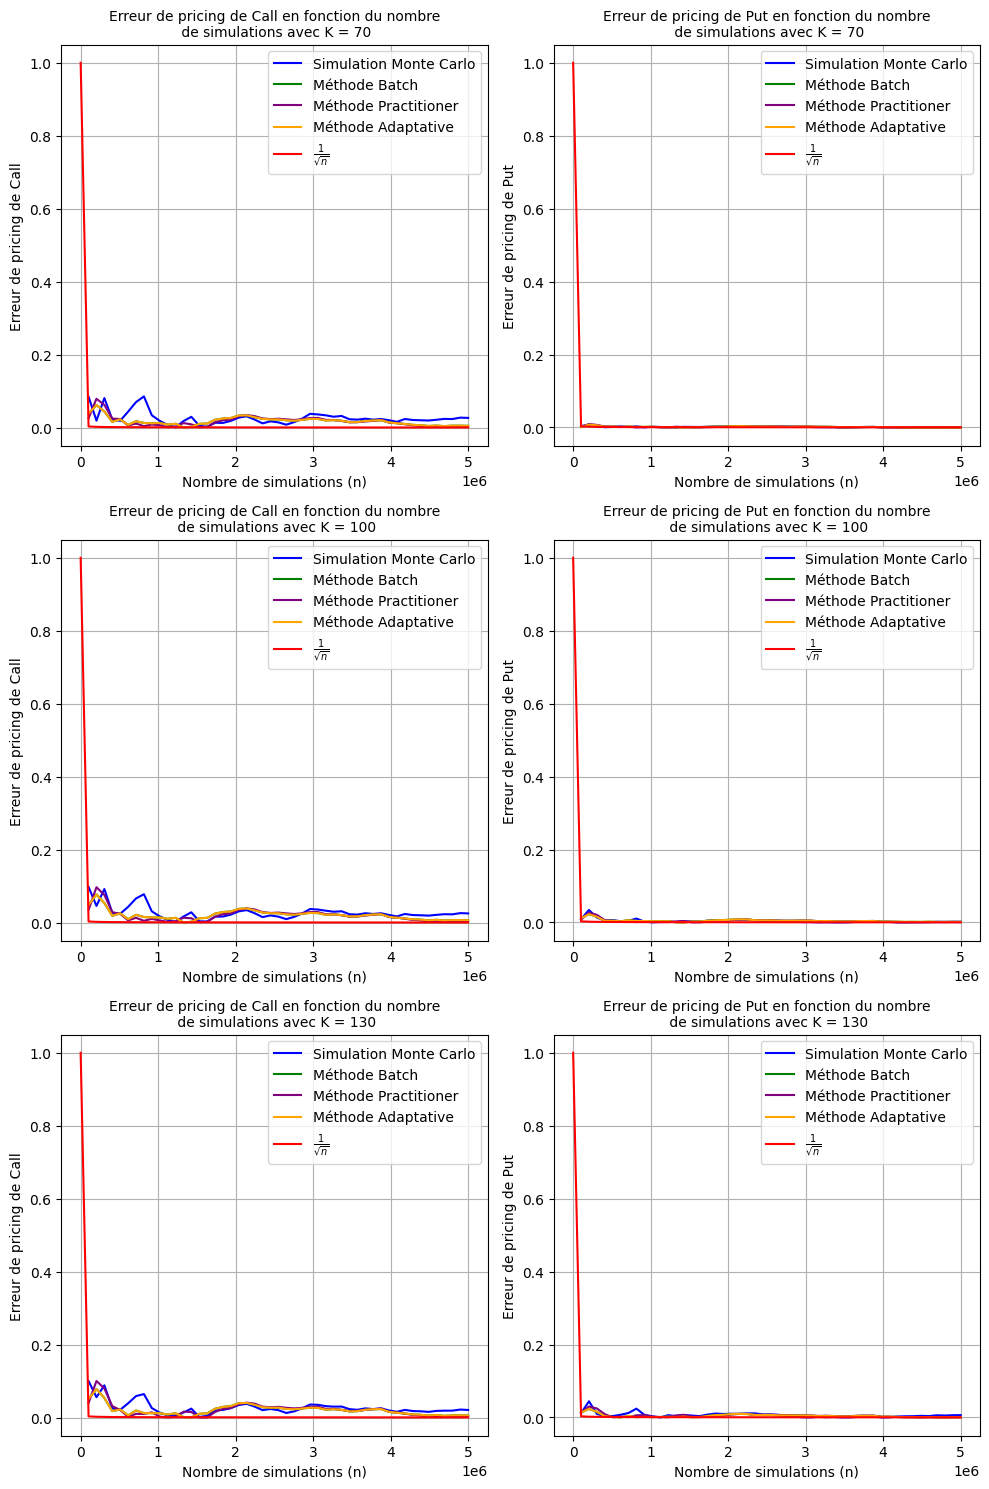

Temps de génération des 5,000,000 prix : 0.14 secondes
Temps de calcul des séries d'estimateurs pour chaque K et chaque fonction de payoff : 4.68 secondes
Temps de tracé : 0.36 secondes
Temps d'exécution total pour une série totale de 2,400 méthodes Monte Carlo : 5.38 secondes


In [29]:
# Nous traçons les graphiques pour comparer la convergence de chaque méthode et indicateur avec 1 / sqrt(n)
# Une première version naïve sans zoom (le graphique sera déformé par les premières valeurs)
beginning = time.time()
print_data_convergence_error_according_to_n(
    S0_CV, r_CV, sigma_CV, T_CV, K_CV, n_CV, prix_option, payoff_function, option_type, nb_simu_wanted)
end = time.time() 
execution_time = end - beginning
print(f"Temps d'exécution total pour une série totale de {16 * len(K_CV) * nb_simu_wanted:,} méthodes Monte Carlo : {execution_time:.2f} secondes")

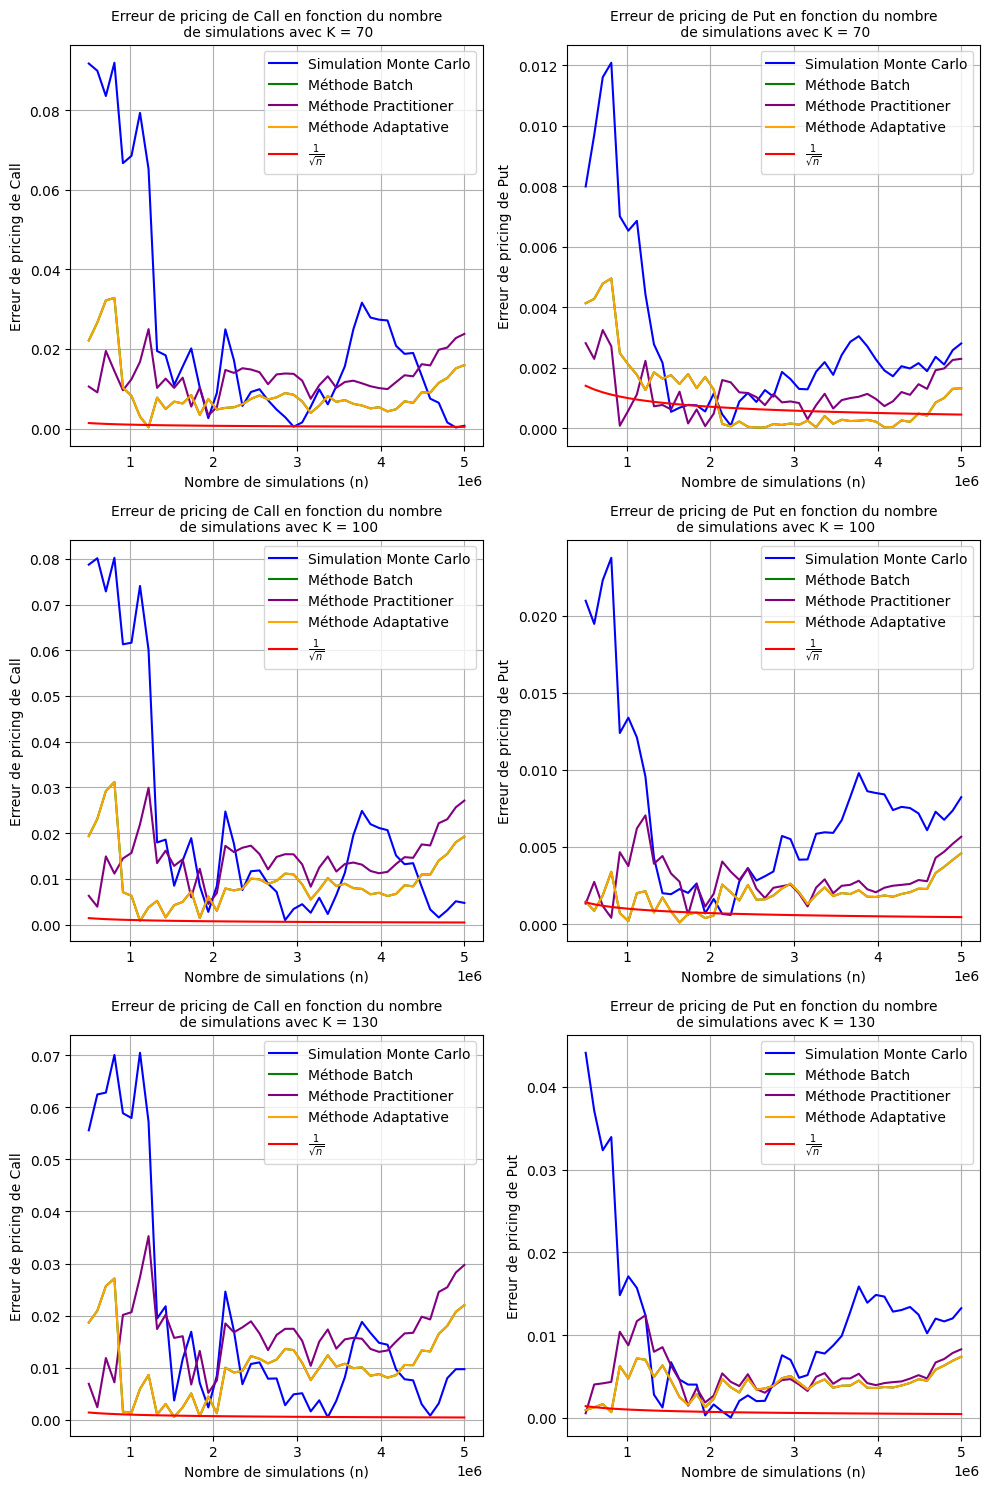

Temps de génération des 5,000,000 prix : 0.11 secondes
Temps de calcul des séries d'estimateurs pour chaque K et chaque fonction de payoff : 4.86 secondes
Temps de tracé : 0.38 secondes
Temps total d'exécution pour une série totale de 2,400 méthodes Monte Carlo : 5.38 secondes


In [31]:
# Nous appliquons une approche pour zoomer uniquement sur les données à la fin de la série,
# afin de supprimer l'effet de la rapide convergence (CV) près de 0.
# La simulation Monte Carlo est relancée, ce qui signifie que les courbes générées ici
# sont différentes de celles tracées précédemment.
beginning = time.time()
print_data_convergence_error_according_to_n(S0_CV, r_CV, sigma_CV, T_CV, K_CV, n_CV, prix_option, payoff_function, option_type, nb_simu_wanted, zoom=0.1)
end = time.time()
execution_time = end - beginning
print(f"Temps total d'exécution pour une série totale de {16*len(K_CV)*nb_simu_wanted:,} méthodes Monte Carlo : {execution_time:.2f} secondes")

Nous observons les caractéristiques principales suivantes : 
- La convergence de l'erreur suit le taux $0\left(\frac{1}{\sqrt{n}} \right) \to 0 \quad \text{lorsque} \quad n \to \infty$.
- Une meilleure convergence asymptotique pour les méthodes utilisant une réduction de variance par rapport à la méthode Monte Carlo naïve (les tests avec des valeurs de n plus élevées, en réduisant le nombre de points, prennent un peu plus de temps), qui présente une variance élevée.
- Les courbes de la méthode Batch et de la méthode Adaptative se superposent. -> Cela est lié à la convergence asymptotique des résultats des méthodes Batch et Adaptative (pour $k$ grand, $\lambda_k \approx \lambda_{k-1}$ et $\tilde{\lambda}_k = \lambda_k$).

#### 3.3. Représentation graphique des différences entre les prix BS et l'estimateur pour plusieurs strikes

In [32]:
S0_strikes = 100     # Prix intial de l'actif sous-jacent
r_strikes = 0.05     # Taux sans risque
sigma_strikes = 0.2  # Volatilité
T_strikes = 8        # Maturité
strikes = [strike for strike in range(80, 125, 5)]  # Prix d'exercices
number_strikes = [1000000,5000000,10000000]  # Nb de simulations


Temps de génération des prix pour n = 10,000,000 : 0.19 secondes


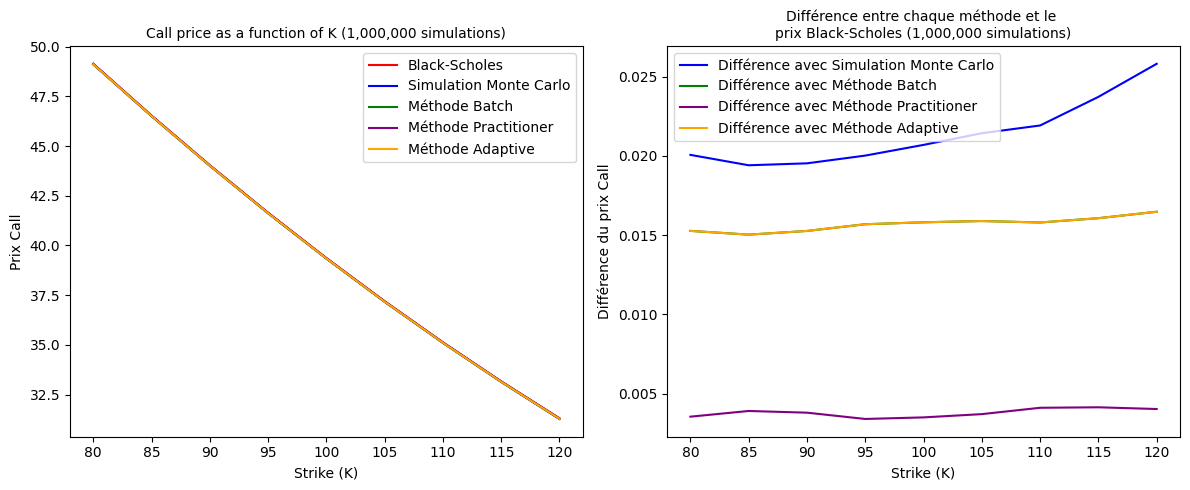

Temps d'exécution des méthodes pour n = 1,000,000 simulations : 0.07 secondes


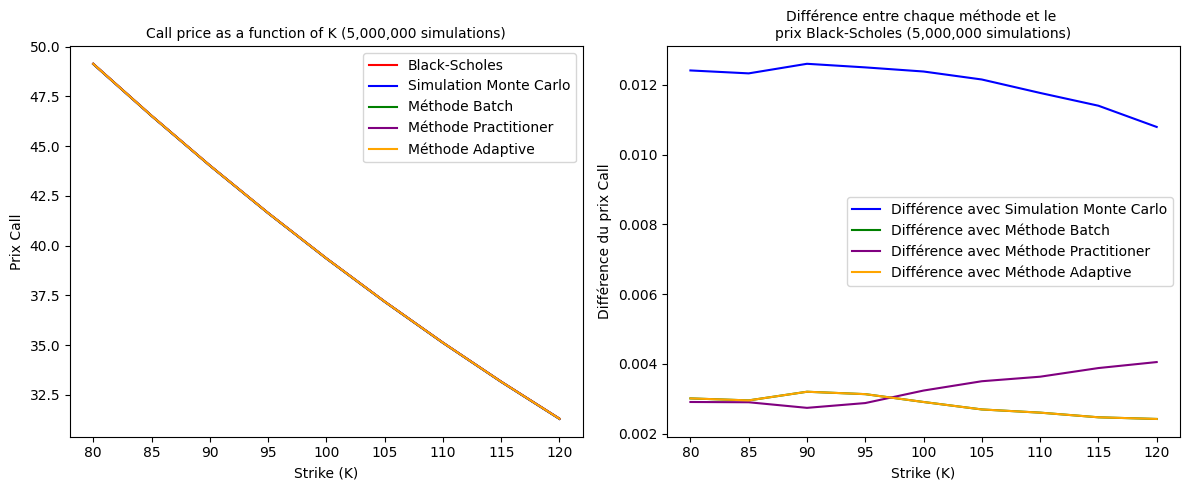

Temps d'exécution des méthodes pour n = 5,000,000 simulations : 0.44 secondes


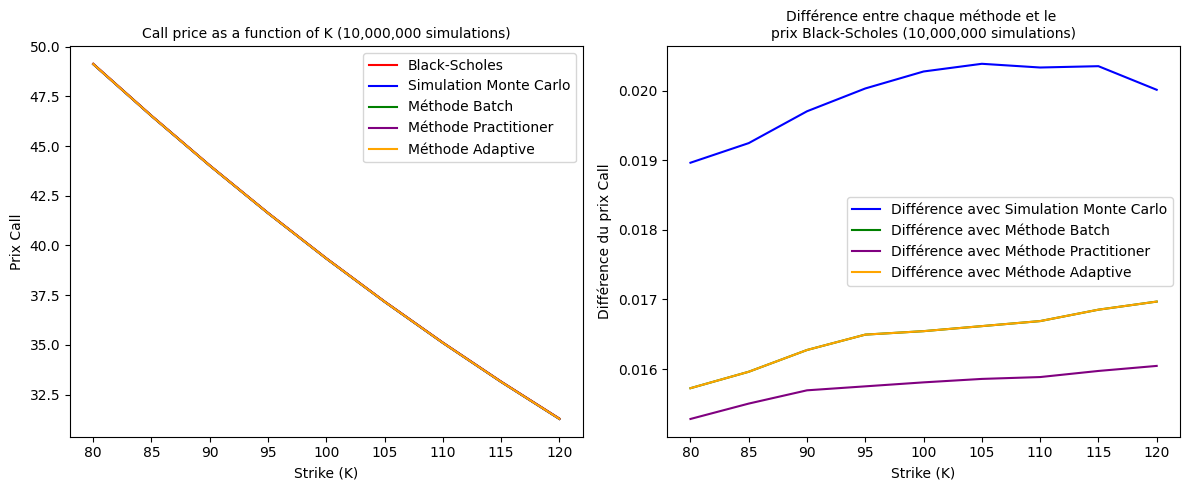

Temps d'exécution des méthodes pour n = 10,000,000 simulations : 0.88 secondes
Temps de génération des prix pour n = 10,000,000 : 0.17 secondes


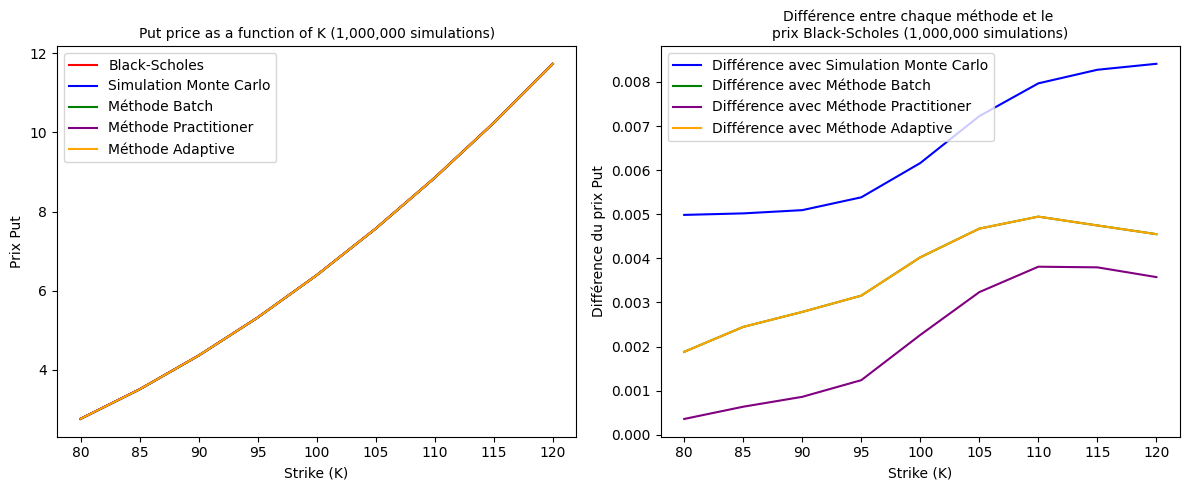

Temps d'exécution des méthodes pour n = 1,000,000 simulations : 0.09 secondes


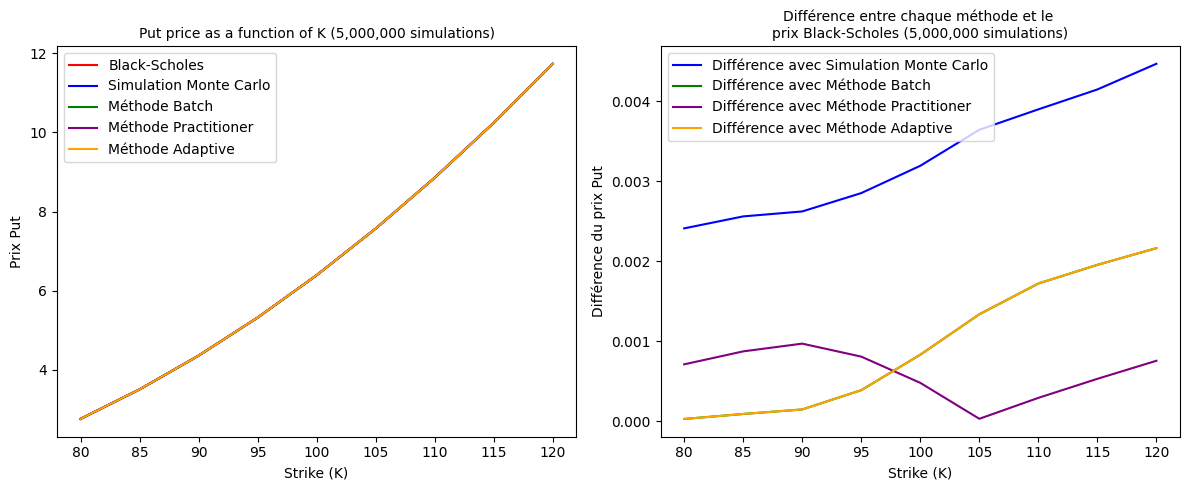

Temps d'exécution des méthodes pour n = 5,000,000 simulations : 0.41 secondes


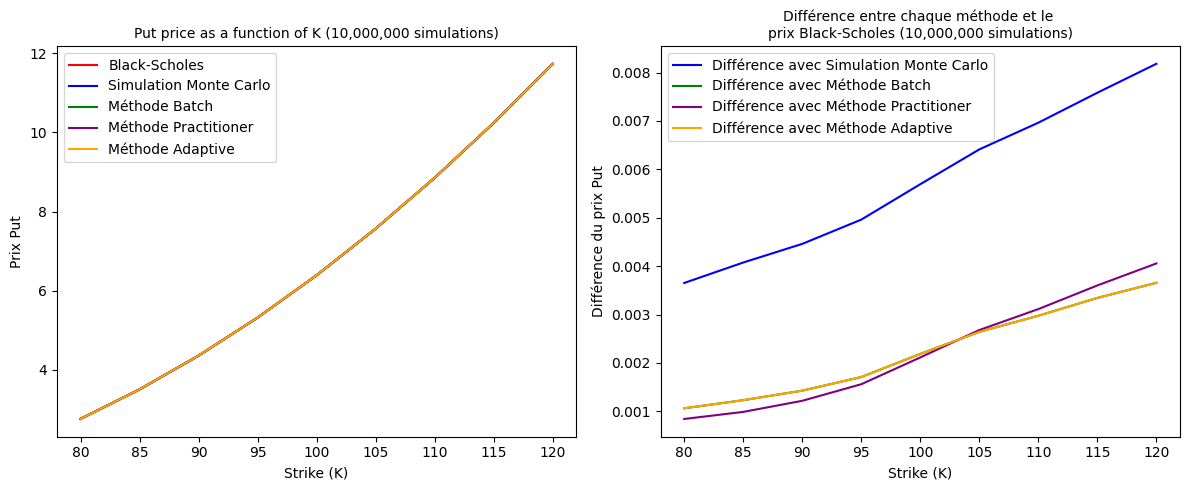

Temps d'exécution des méthodes pour n = 10,000,000 simulations : 0.76 secondes


In [33]:
plot_result (S0_strikes,r_strikes,sigma_strikes,T_strikes,strikes,number_strikes,call_price,payoff_call,option_type="Call")
plot_result (S0_strikes,r_strikes,sigma_strikes,T_strikes,strikes,number_strikes,put_price,payoff_put,option_type="Put")

Nous avons les principales caractéristiques suivantes : 
- Les erreurs diminuent à mesure que le nombre de simulations augmente.
- La méthode utilisant des techniques de réduction de variance donne de meilleures performances d’un point de vue asymptotique et pour toutes les valeurs de strikes.
- Selon la nature de notre option, si elle est largement hors de la monnaie (call) ou dans la monnaie (put), nos erreurs augmentent légèrement.
- Convergence asymptotique des résultats des méthodes Batch et Adaptive (pour $k$ grand, $\lambda_k \approx \lambda_{k-1}$ et $\tilde{\lambda_k} = \lambda_k$).